In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [13]:
class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

        
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(20 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    x_train = x_[:training_size, :]
    y_train = y_[:training_size, :]

    x_val = x_[training_size:, :]
    y_val = y_[training_size:, :]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    y_train_pred = my_network(x_train).reshape(-1,)
    y_val_pred = my_network(x_val).reshape(-1,)
    y_test_pred = my_network(x_test).reshape(-1,)
    
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print('Relative Training Error:', relative_error_train.detach().numpy() ** 0.5 * 100, '%')
    
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print('Relative Validation Error:', relative_error_val.detach().numpy() ** 0.5 * 100, '%')
    
    plt.figure(figsize=(16, 8))
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
    plt.plot(np.arange(1,n_epochs+1), history[1], label="Validation Loss")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
#     plt.figure(figsize=(16, 8))
#     plt.grid(True, which="both", ls=":")
#     plt.scatter(x_train[:,0], y_train, label="Training Data", marker="o", color="C0")
#     plt.scatter(x_val[:,0], y_val, label="Validation Data", marker="*", color="C1", s=100)
#     plt.scatter(x_test[:,0], y_test_pred.detach(), label="Network Prediction",lw=2, color="black", ls="-.")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend()
#     plt.show()
    
    return y_test_pred

In [14]:
def fit_(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        history[0].append(running_loss[0])
        history[1].append(0)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

def run_single_configuration_(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_, y_), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit_(my_network, training_set, n_epochs, optimizer_, p=2, verbose=False)

    y_train = y_.reshape(-1,)
    y_train_pred = my_network(x_).reshape(-1,)
    y_test_pred = my_network(x_test).reshape(-1,)
    
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print('Relative Training Error:', relative_error_train.detach().numpy() ** 0.5 * 100, '%')
    
    plt.figure(figsize=(16, 8))
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
    return y_test_pred

In [15]:
with open('TrainingData_1601.txt', 'r') as f:
    data_y = []
    lines = f.readlines()
    for line in lines:
        data_y.append(float(line.split(' ')[-1]))
    data_y = np.array(data_y).reshape(-1,1)
    n_samples = data_y.shape[0]
    
with open('samples_sobol.txt', 'r') as f:
    data_x = []
    lines = f.readlines()
    for line in lines[:n_samples]:
        data_x.append([float(s) for s in line.split(' ')])
    data_x = np.array(data_x)
    
data = np.hstack((data_x, data_y))
np.random.seed(42)
np.random.shuffle(data)

with open('TestingData.txt', 'r') as f:
    data_test = []
    lines = f.readlines()
    for line in lines:
        data_test.append([float(s) for s in line.split(' ')])
    data_test = np.array(data_test)

In [16]:
x = torch.from_numpy(data[:,:8]).float()
y = torch.from_numpy(data[:,8].reshape(-1,1)).float()
x_test = torch.from_numpy(data_test).float()

#################### 0 ####################
{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 10, 'activation': 'tanh'}
Final Training Loss:  1.44e-06
Final Validation Loss:  0
Relative Training Error: 0.2837462117895484 %


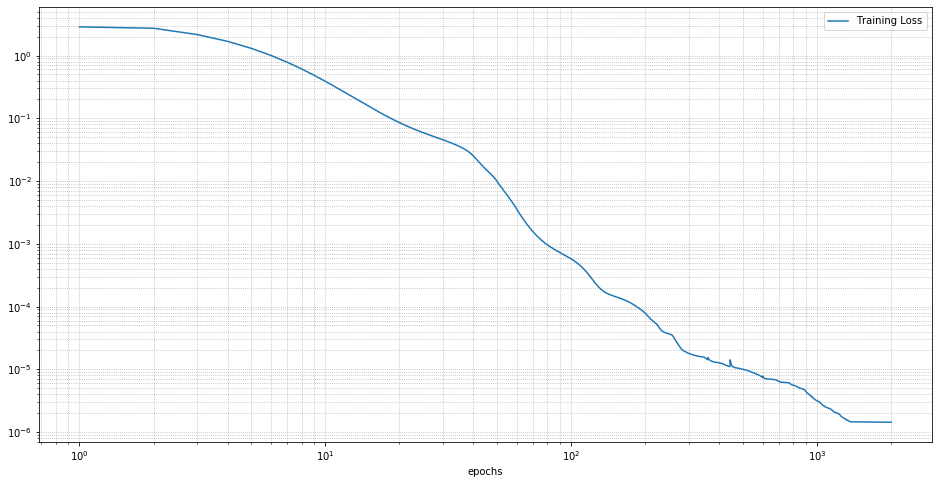

#################### 1 ####################
{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 20, 'activation': 'tanh'}
Final Training Loss:  1.72e-06
Final Validation Loss:  0
Relative Training Error: 0.3105280688032508 %


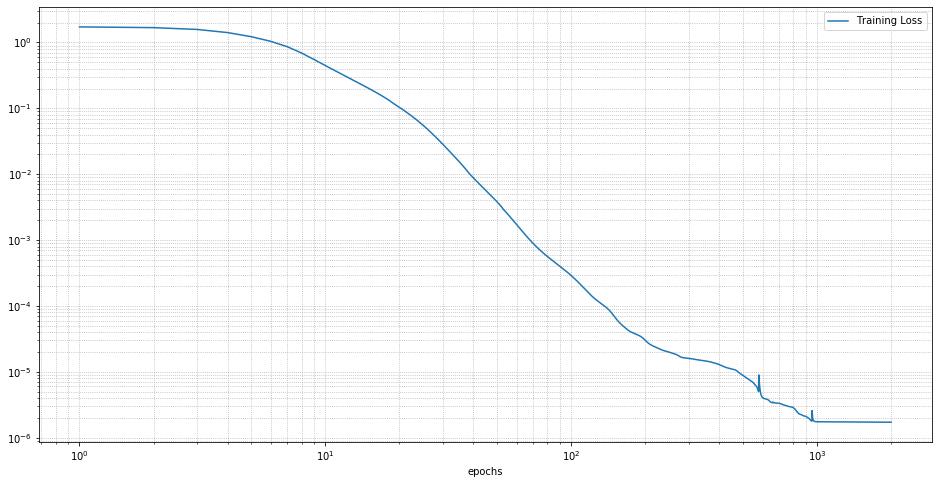

#################### 2 ####################
{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  1.74e-06
Final Validation Loss:  0
Relative Training Error: 0.3121863352134824 %


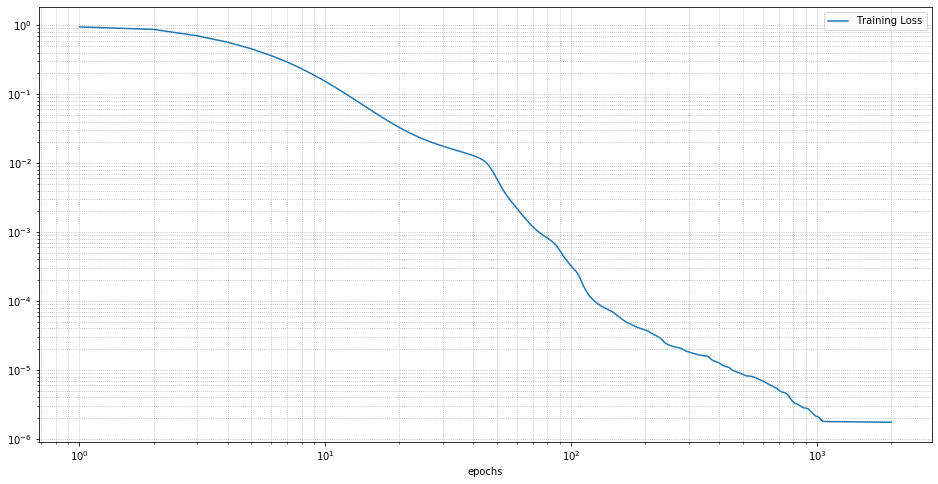

#################### 3 ####################
{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  3.94e-06
Final Validation Loss:  0
Relative Training Error: 0.4697463009506464 %


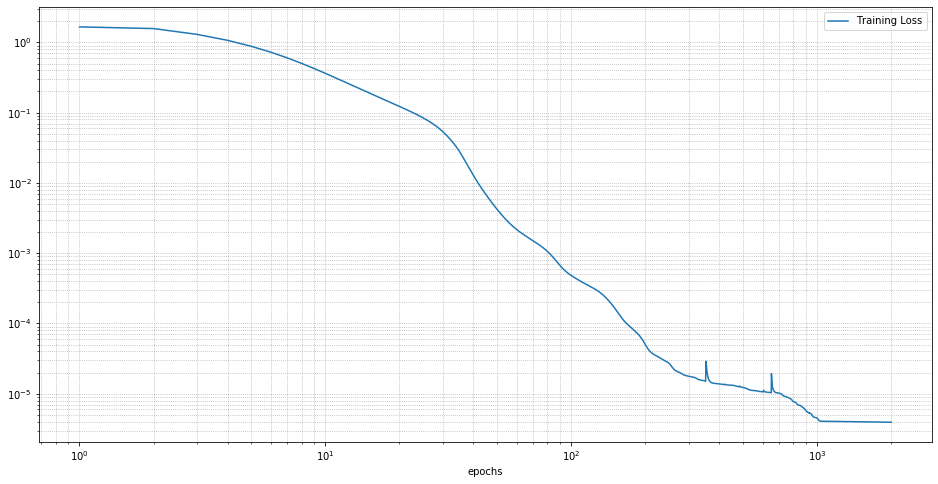

#################### 4 ####################
{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 134, 'activation': 'tanh'}
Final Training Loss:  2.17e-06
Final Validation Loss:  0
Relative Training Error: 0.34903071355074644 %


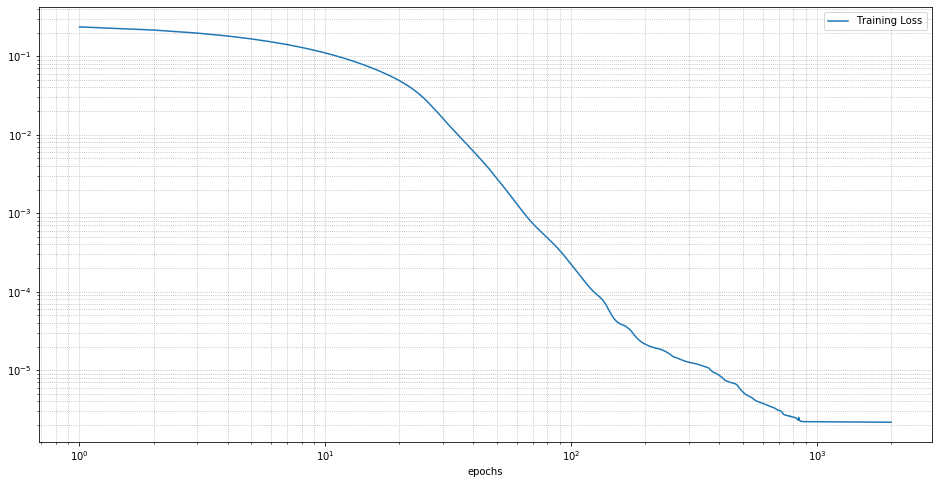

In [18]:
hyperparameters_configurations = {
    "epochs": [2000],
    "hidden_layers": [2],
    "neurons": [10],
    "regularization_exp": [2],
    "regularization_param": [0],
    "batch_size": [n_samples],
    "optimizer": ["LBFGS"],
    "init_weight_seed": [10, 20, 567, 34, 134],
    "activation": ["tanh"]
}

settings = list(itertools.product(*hyperparameters_configurations.values()))

for set_num, setup in enumerate(settings):
    print('####################', set_num, '####################')
    setup_properties = {
        'epochs': setup[0],
        'hidden_layers': setup[1],
        'neurons': setup[2],
        'regularization_exp': setup[3],
        'regularization_param': setup[4],
        'batch_size': setup[5],
        'optimizer': setup[6],
        'init_weight_seed': setup[7],
        'activation': setup[8]
    }
    
    run_single_configuration_(setup_properties, x, y)

{'epochs': 2000, 'hidden_layers': 2, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 10, 'activation': 'tanh'}
Final Training Loss:  1.44e-06
Final Validation Loss:  0
Relative Training Error: 0.2837462117895484 %


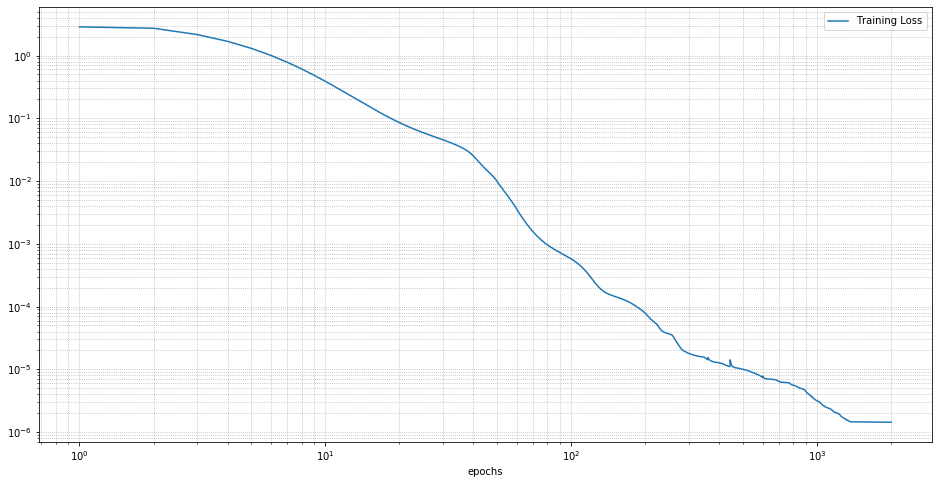

In [19]:
setup_properties = {
    'epochs': 2000,
    'hidden_layers': 2,
    'neurons': 10,
    'regularization_exp': 2,
    'regularization_param': 0,
    'batch_size': n_samples,
    'optimizer': 'LBFGS',
    'init_weight_seed': 10,
    'activation': 'tanh'
}

y_test_pred = run_single_configuration_(setup_properties, x, y).detach().numpy()

In [11]:
with open('Task2.txt', 'w') as f:
    for i in range(y_test_pred.size):
        f.write(f'{y_test_pred[i]:.13e}\n')